<a href="https://colab.research.google.com/github/colab-ds18/ML-DS18/blob/main/ML_DS18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
'''
General Funtions Author OA
Date 29/01/2025
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.ensemble import RandomForestRegressor  # For the Random Forest regression model
import shap
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_log_error

def show_unique_values(df, column_name):
  '''
  Function to list all unique values in a given column of a DataFrame.
  '''
  if column_name not in df.columns:
    raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    unique_products = list_unique_values(df, column_name)
    print(unique_products)
    null_stats_per_column(df,column_name)


def list_unique_values(df, column_name):
    """
    Function to list all unique values in a given column of a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column_name: Name of the column to find unique values

    Returns:
    - A list of unique values in the specified column.
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    unique_values = df[column_name].unique()
    return unique_values


def update_NaN_To_None_or_Unspecified(df):
    """
    Updates NaN values to 'None or Unspecified' in columns where the value
    'None or Unspecified' is already present.
    """
    update_to = 'None or Unspecified'

    for col in df.columns:
        unique_values = list_unique_values(df, col)  # Get unique values for the column

        # Check if 'None or Unspecified' exists and if there are NaN values
        if update_to in unique_values and pd.isnull(unique_values).any():
            df[col] = df[col].fillna(update_to)  # Fill NaN with the specified value
            print(f"Updated '{col}' column successfully!")
        else:
            print(f"Column '{col}' does not have the required conditions for update.")

    return df

def columns_with_nulls(df,only_numeric_columns=True):
  '''
  Function to list all columns with null values in a given DataFrame.
  '''
  if only_numeric_columns:
    # Get numeric columns only
    numeric_columns = df.select_dtypes(include=['number'])

    # Find numeric columns with null values
    numeric_columns_with_null = numeric_columns.columns[numeric_columns.isnull().any()]
    return numeric_columns_with_null.tolist()
  else:
    return df.columns[df.isnull().any()]


def null_stats_per_column(df,chosen_column):
  '''
  Function to display the number of null rows in a given column of a DataFrame.
  '''
  # Count the number of null rows in the chosen column
  null_count = df[chosen_column].isnull().sum()

  # Calculate the percentage of nulls in the chosen column
  null_percentage = (null_count / len(df)) * 100

  # Display the result
  print(f"Column: {chosen_column}")
  print(f"Null Count: {null_count}")
  print(f"Null Percentage: {null_percentage:.2f}%")


def missing_values_histogram(df,columns):
    '''
    Function to plot a histogram of missing values in a given DataFrame.
    '''
    data=[{column:df[column].value_counts().sum()} for column in columns ]
    # Convert the list of dictionaries to a DataFrame
    formatted_data = pd.DataFrame([{name:count for single_data in data for name, count in single_data.items()}]).T.reset_index()
    formatted_data.columns = ['Column', 'Count']
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Column', y='Count', data=formatted_data, hue='Column',legend=False)


    # label count on top of each bar
    for index, row in formatted_data.iterrows():
        ax.text(index, row['Count'] + 10, str(row['Count']), color='black', ha="center", fontsize=10)

    # Add title and axis labels
    plt.title("Column Counts in Dataframe")
    plt.xlabel("Column")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def encode_all_categories(df):
  '''
  Function to convert all string columns in a given DataFrame into categories.
  '''
  for col in df.select_dtypes(['object']):
    df[col] = df[col].astype('category')

  for col in df.select_dtypes(['category']):
    df[col] = df[col].cat.codes

  return df

def drop_nulls(df):
  '''
  Function to drop all rows with null values in a given DataFrame.
  '''
  df = df.dropna()
  return df

def RMSLE(y_test, y_pred):
    '''
    RSMLE approximates the percent change
    '''
    return np.sqrt(np.mean((np.log(y_pred) - np.log(y_test))**2))

def RMSE(y_, y_pred_):
    '''
    RSME
    '''
    return ((y_ - y_pred_) ** 2).mean() ** 0.5

def train_model(df,column_to_predict,test_size_value=0.3,random_state_value=42):
    '''
    Function to train a Random Forest regression model on a given DataFrame.
    '''
    X = df.drop(columns=[column_to_predict])
    y = df[column_to_predict]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_value, random_state=random_state_value)

    # model = DecisionTreeRegressor(
    # min_samples_leaf=16
    # max_depth=3
    # )
    #model = LinearRegression()
    model = RandomForestRegressor()
    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 7. print the RMSE accuracy of the baseline (std dev)
    print("RMSE Baseline accuracy:", y_test.std())
    print("Train RMSE:", RMSE(y_train, y_train_pred))
    print("Test RMSE:", RMSE(y_test, y_test_pred))
    print("Test RMSLE:", RMSLE(y_test, y_test_pred))

    #display(pd.Series(model.feature_importances_, model.feature_names_in_).sort_values(ascending=False))
    return model,(X_train, X_test, y_train, y_test)

def feature_importances(model):
  '''
  Function to display the feature importances of a given Random Forest regression model.
  '''
  dict(zip(model.feature_names_in_, model.feature_importances_))
  fi = pd.Series(model.feature_importances_, index=model.feature_names_in_)
  fi = fi.sort_values(ascending=False)
  print(fi)

  return fi

def explain_model_snap(model,X_test,water_fall_row=0):
  '''
  Function to explain the model's predictions using SHAP values.
  '''
  shap.initjs()
  explainer = shap.Explainer(model)
  explanation = explainer(X_test)  # New style
  shap.summary_plot(explanation, X_test)

  shap.plots.waterfall(explanation[water_fall_row])

  shap.plots.waterfall(explanation[water_fall_row+2])

  shap.plots.partial_dependence('fare', model.predict, X_test, feature_names=X_test.columns)

  shap.plots.heatmap(explanation)

  shap.plots.bar(explanation)


def find_outliers(df, column_to_predict, test_size_value=0.3, random_state_value=42):
    """
    Identify outliers using Isolation Forest and add anomaly-related columns to the DataFrame.

    Parameters:
    - df: Input DataFrame.
    - column_to_predict: Column to exclude for training the Isolation Forest.
    - test_size_value: Test size for train-test split.
    - random_state_value: Random state for reproducibility.

    Returns:
    - A new DataFrame with additional columns: 'anomaly_score', 'anomaly', and 'anomaly_label'.
    """
    # Create features (X) and target (y)
    X = pd.get_dummies(df.drop(columns=[column_to_predict]), drop_first=True)
    y = df[column_to_predict]

    # Train Isolation Forest on the entire dataset (no splitting)
    iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=random_state_value)
    iso_forest.fit(X)

    # Predict anomaly scores and labels
    df = df.copy()  # Work on a copy of the DataFrame
    df['anomaly_score'] = iso_forest.decision_function(X)  # Quantitative anomaly score
    df['anomaly'] = iso_forest.predict(X)  # Binary anomaly label (1 for normal, -1 for anomaly)
    df['anomaly_label'] = df['anomaly'].map({1: 'Normal', -1: 'Anomaly'})  # Map labels

    return df



def convert_date_columns(df, date_column):
    """
    Convert date column into multiple numeric features like year, month, day, etc.
    Handles potential issues like missing date_column or invalid data.
    """
    # Ensure the date_column exists in the DataFrame
    if date_column not in df.columns:
        raise KeyError(f"Column '{date_column}' does not exist in the DataFrame.")

    # Convert the column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')  # Handle invalid date strings

    # Check if any date values are invalid after conversion
    if df[date_column].isnull().all():
        raise ValueError(f"All values in '{date_column}' could not be converted to datetime.")

    # Extract date features
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['is_weekend'] = df['day_of_week'] >= 5  # Saturday=5, Sunday=6

    # Drop the original date column
    df = df.drop(columns=[date_column])

    return df

#    model = RandomForestRegressor(random_state=42, n_jobs=-1)
#    xs=(X_train, X_test, y_train, y_test)
def perm_importance_model(model, xs):
    '''
    Function to compute Permutation Importance of a given Random Forest regression model.
    '''
    X_train, X_test, y_train, y_test = xs

    # Compute Permutation Importance
    perm_importance = permutation_importance(
        model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
    )

    # Create the results DataFrame
    importance_model = pd.DataFrame({
        "Feature": model.feature_names_in_,
        "Permutation Importance": perm_importance.importances_mean,
        "Permutation Std Deviation": perm_importance.importances_std,
        "Model Importance": model.feature_importances_,
    })

    # Add ranking for permutation and model importances
    importance_model["Permutation Rank"] = importance_model["Permutation Importance"].rank(ascending=False)
    importance_model["Model Rank"] = importance_model["Model Importance"].rank(ascending=False)

    # Sort by Permutation Importance for display
    importance_model = importance_model.sort_values(by="Permutation Importance", ascending=False)

    # Display the DataFrame
    display(importance_model)

    return importance_model

def load_dataframe_from_drive():
    """
    Function to load a DataFrame from a Google Drive file path.
    """
    from google.colab import drive
    drive.mount('/content/drive')

    # Load the file from Google Drive
    file_path = "/content/drive/My Drive/Train.csv"  # Replace with the saved file path
    df = pd.read_csv(file_path)
    return df

def summarize_null_columns(dataframe):
    """
    Function to find columns with null values and display detailed information
    including column name, total null count, percentage of nulls, and data type.
    """
    # Find total nulls and percentage of nulls for each column
    columns_with_nulls = dataframe.isnull().sum()  # Total nulls per column
    null_percentage = (columns_with_nulls / len(dataframe)) * 100  # Percentage of nulls

    # Iterate through columns and display only those with null values
    for col in dataframe.columns:
        if columns_with_nulls[col] > 0:  # Check if the column has nulls
            col_dtype = dataframe[col].dtype  # Get column data type
            print(f"Column: {col}")
            print(f"  - Data Type: {col_dtype}")
            print(f"  - Total Null Rows: {columns_with_nulls[col]}")
            print(f"  - Percentage of Nulls: {null_percentage[col]:.2f}%")
            print("-" * 40)

def drop_columns_with_high_nulls(dataframe, threshold=500):
    """
    Function to drop columns from the DataFrame that have more than 'threshold' null values.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.
    threshold (int): The maximum allowable null rows for a column. Columns with nulls > threshold will be dropped.

    Returns:
    pd.DataFrame: A new DataFrame with columns dropped based on the condition.
    """
    # Identify columns with null counts greater than the threshold
    columns_to_drop = dataframe.columns[dataframe.isnull().sum() > threshold]

    # Drop these columns from the DataFrame
    cleaned_dataframe = dataframe.drop(columns=columns_to_drop)

    print(f"Dropped columns: {list(columns_to_drop)}")
    return cleaned_dataframe



In [12]:
df=load_dataframe_from_drive()

Mounted at /content/drive


<ipython-input-11-8ecec07626b7>:313: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


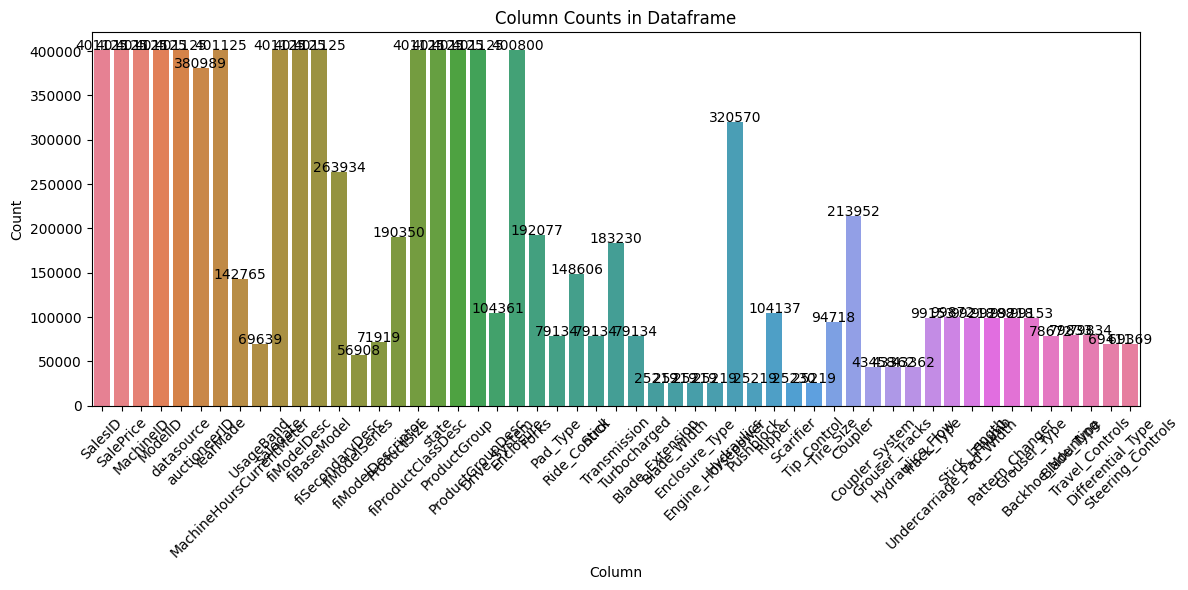

In [13]:
missing_values_histogram(df,df.columns)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

In [15]:
df.describe()


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06


In [16]:
# Update the 'MachineHoursCurrentMeter' column: replace NaN or 0 with 0
column_name = 'MachineHoursCurrentMeter'

# Check if the column exists
if column_name in df.columns:
    df[column_name] = df[column_name].fillna(0)  # Replace NaN with 0
    df[column_name] = df[column_name].replace(0, 0)  # Ensure 0 stays 0
    print(f"Updated '{column_name}' column successfully!")
else:
    print(f"Column '{column_name}' does not exist in the DataFrame.")


Updated 'MachineHoursCurrentMeter' column successfully!


In [17]:
df['auctioneerID'].max()
df['auctioneerID'].min()

# Assuming 'df' is your DataFrame
# Fill null values in the 'auctioneerID' column with 100.0
if 'auctioneerID' in df.columns:
    df['auctioneerID'] = df['auctioneerID'].fillna(100.0)
    print("'auctioneerID' null values filled with 100.0 successfully!")
else:
    print("Column 'auctioneerID' does not exist in the DataFrame.")


'auctioneerID' null values filled with 100.0 successfully!


In [18]:
print("columns with null values:", columns_with_nulls(df,False))


columns with null values: Index(['UsageBand', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')


In [19]:

# Example usage:
# Assuming 'df' is your DataFrame
summarize_null_columns(df)


Column: UsageBand
  - Data Type: object
  - Total Null Rows: 331486
  - Percentage of Nulls: 82.64%
----------------------------------------
Column: fiSecondaryDesc
  - Data Type: object
  - Total Null Rows: 137191
  - Percentage of Nulls: 34.20%
----------------------------------------
Column: fiModelSeries
  - Data Type: object
  - Total Null Rows: 344217
  - Percentage of Nulls: 85.81%
----------------------------------------
Column: fiModelDescriptor
  - Data Type: object
  - Total Null Rows: 329206
  - Percentage of Nulls: 82.07%
----------------------------------------
Column: ProductSize
  - Data Type: object
  - Total Null Rows: 210775
  - Percentage of Nulls: 52.55%
----------------------------------------
Column: Drive_System
  - Data Type: object
  - Total Null Rows: 296764
  - Percentage of Nulls: 73.98%
----------------------------------------
Column: Enclosure
  - Data Type: object
  - Total Null Rows: 325
  - Percentage of Nulls: 0.08%
-----------------------------------

In [20]:

# Example usage:
df = drop_columns_with_high_nulls(df, threshold=500)
print(df.head())

Dropped columns: ['UsageBand', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'Drive_System', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']
   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.

In [21]:
# Replace null values in the 'Enclosure' column with 'N/A'
if 'Enclosure' in df.columns:
    df['Enclosure'] = df['Enclosure'].fillna('N/A')
    print("Replaced null values in the 'Enclosure' column with 'N/A'.")
else:
    print("Column 'Enclosure' does not exist in the DataFrame.")


Replaced null values in the 'Enclosure' column with 'N/A'.


In [22]:
df=convert_date_columns(df,'saledate')
df.head()


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Enclosure,year,month,day,day_of_week,is_weekend
0,1139246,66000,999089,3157,121,3.0,2004,68.0,521D,521,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,EROPS w AC,2006,11,16,3,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,950FII,950,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,EROPS w AC,2004,3,26,4,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,226,226,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,OROPS,2004,2,26,3,False
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,PC120-6E,PC120,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,EROPS w AC,2011,5,19,3,False
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,S175,S175,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,EROPS,2009,7,23,3,False


In [23]:
df=encode_all_categories(df)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Enclosure,year,month,day,day_of_week,is_weekend
0,1139246,66000,999089,3157,121,3.0,2004,68.0,949,295,58,0,5,5,2,2006,11,16,3,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,1724,526,61,32,5,5,2,2004,3,26,4,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,330,109,38,31,2,2,6,2004,2,26,3,False
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,3673,1374,7,43,3,3,2,2011,5,19,3,False
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,4207,1528,39,31,2,2,0,2009,7,23,3,False


In [24]:
#train_model(df=df,column_to_predict='SalePrice')#took 8 min runtime

RMSE Baseline accuracy: 22932.4005340408 Train RMSE: 2864.123815046 Test RMSE: 7633.339248575835 0 Enclosure 0.240869 YearMade 0.147308 fiProductClassDesc 0.117304 fiModelDesc 0.099289 ModelID 0.093105 year 0.080002 SalesID 0.043689 fiBaseModel 0.033948 ProductGroup 0.032850 ProductGroupDesc 0.029777 MachineID 0.023082 day 0.013131 month 0.013108 state 0.012552 auctioneerID 0.006424 day_of_week 0.006194 MachineHoursCurrentMeter 0.005897 datasource 0.000885 is_weekend 0.000586

In [25]:
sampled_df = df.sample(n=25000, random_state=42)  # Example: 10,000 rows

model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22875.826680148548
Train RMSE: 4018.848398774561
Test RMSE: 10680.741241938615
Test RMSLE: 0.31828407504371004


In [26]:
feature_importances(model)

Enclosure                   0.211314
YearMade                    0.150981
fiProductClassDesc          0.106246
ModelID                     0.085136
fiModelDesc                 0.077537
year                        0.067787
fiBaseModel                 0.053704
SalesID                     0.049438
MachineID                   0.046440
ProductGroup                0.034519
ProductGroupDesc            0.032724
day                         0.019179
state                       0.019139
month                       0.014987
auctioneerID                0.009906
day_of_week                 0.009204
MachineHoursCurrentMeter    0.009132
datasource                  0.001703
is_weekend                  0.000926
dtype: float64


,0
Enclosure,0.211314
YearMade,0.150981
fiProductClassDesc,0.106246
ModelID,0.085136
fiModelDesc,0.077537
year,0.067787
fiBaseModel,0.053704
SalesID,0.049438
MachineID,0.046440
ProductGroup,0.034519


In [27]:
sampled_df = sampled_df.drop(columns=['is_weekend','datasource','MachineHoursCurrentMeter','day_of_week','auctioneerID'], errors='ignore')  # 'errors="ignore"' prevents errors if columns don't exist



In [28]:
model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22875.826680148548
Train RMSE: 4007.1077356546352
Test RMSE: 10681.063526084044
Test RMSLE: 0.318492984041578


In [29]:
sampled_df=find_outliers(df=sampled_df,column_to_predict='SalePrice')

In [30]:
print(sampled_df)

        SalesID  SalePrice  MachineID  ModelID  YearMade  fiModelDesc  \
347851  2404577      35000    1123369     9133      2005         4858   
361528  2501703      27000    1448367    22353      2003         1579   
296035  2227746      66000    1062020     4035      1988         1950   
165866  1590101      43000    1116102     8165      1990          905   
303180  2248487      92000    1224931     4149      1993         2366   
...         ...        ...        ...      ...       ...          ...   
135819  1493894      37000    1272987     2759      1994         2199   
68214   1344737      33000     651831     4124      1981         2276   
10508   1174457      43000    1043454     3362      1985          105   
172913  1602017      32000    1489667    22057      1999          223   
301605  2244611      70000    1080310     2768      1995         2327   

        fiBaseModel  fiProductClassDesc  state  ProductGroup  \
347851         1873                   1     23             

In [31]:
# Assuming df_with_anomalies is the DataFrame containing anomaly labels
anomalies = sampled_df[sampled_df['anomaly_label'] == 'Anomaly']

# Display rows where 'anomaly_label' is 'Anomaly'
print(anomalies)

# Optionally, display the count of anomalies
print(f"Number of anomalies detected: {len(anomalies)}")


        SalesID  SalePrice  MachineID  ModelID  YearMade  fiModelDesc  \
377579  2782984      17000    1801648    20102      1000         4564   
290400  2208036      24000    1668292    13244      1000         1061   
372434  2655917      15000    1789973    26283      1000         1787   
390267  4373994      17500    2294296    17319      2005         4464   
387452  4349685      18500    2281886    24808      2003          274   
...         ...        ...        ...      ...       ...          ...   
346386  2397579      11500     335232      597      1000         4757   
398250  6292968      40000    1906517    25596      2005         4928   
397203  6285995      10500    1819172     4603      1000          489   
233844  1730203      29000    1086897      632      1000         4801   
376734  2742365      16000    1866150    36362      1999         1593   

        fiBaseModel  fiProductClassDesc  state  ProductGroup  \
377579         1742                  42     40             

In [32]:
# Remove all rows where 'anomaly_label' is 'Anomaly'
sampled_df = sampled_df[sampled_df['anomaly_label'] != 'Anomaly']

# Drop the columns 'anomaly_label', 'anomaly_score', and 'anomaly'
columns_to_drop = ['anomaly_label', 'anomaly_score', 'anomaly']
sampled_df = sampled_df.drop(columns=columns_to_drop, errors='ignore')

# Display the updated DataFrame
print(sampled_df.head())

# Optionally display the new shape of the DataFrame
print(f"New DataFrame shape: {sampled_df.shape}")


        SalesID  SalePrice  MachineID  ModelID  YearMade  fiModelDesc  \
347851  2404577      35000    1123369     9133      2005         4858   
361528  2501703      27000    1448367    22353      2003         1579   
296035  2227746      66000    1062020     4035      1988         1950   
165866  1590101      43000    1116102     8165      1990          905   
303180  2248487      92000    1224931     4149      1993         2366   

        fiBaseModel  fiProductClassDesc  state  ProductGroup  \
347851         1873                   1     23             0   
361528          469                  53     43             4   
296035          670                  51      8             4   
165866          283                  26     18             3   
303180          715                  51     22             4   

        ProductGroupDesc  Enclosure  year  month  day  
347851                 0          6  2007      9   12  
361528                 4          6  2010      9   29  
296035  

In [33]:
model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22944.443526091734
Train RMSE: 3899.615458424565
Test RMSE: 10703.990484971799
Test RMSLE: 0.31537802691323413


In [34]:
perm_importance_model(model,xs)

,Feature,Permutation Importance,Permutation Std Deviation,Model Importance,Permutation Rank,Model Rank
3,YearMade,0.648822,0.008516,0.146283,1.0,2.0
6,fiProductClassDesc,0.274886,0.004784,0.115526,2.0,3.0
10,Enclosure,0.242907,0.008619,0.215529,3.0,1.0
11,year,0.210402,0.006654,0.071569,4.0,6.0
4,fiModelDesc,0.168763,0.006457,0.089333,5.0,5.0
2,ModelID,0.109999,0.004210,0.092340,6.0,4.0
5,fiBaseModel,0.089719,0.000945,0.047448,7.0,9.0
9,ProductGroupDesc,0.052907,0.001593,0.030497,8.0,10.0
8,ProductGroup,0.039494,0.001666,0.026191,9.0,11.0
0,SalesID,0.026233,0.001837,0.053165,10.0,7.0


,Feature,Permutation Importance,Permutation Std Deviation,Model Importance,Permutation Rank,Model Rank
3,YearMade,0.648822,0.008516,0.146283,1.0,2.0
6,fiProductClassDesc,0.274886,0.004784,0.115526,2.0,3.0
10,Enclosure,0.242907,0.008619,0.215529,3.0,1.0
11,year,0.210402,0.006654,0.071569,4.0,6.0
4,fiModelDesc,0.168763,0.006457,0.089333,5.0,5.0
2,ModelID,0.109999,0.004210,0.092340,6.0,4.0
5,fiBaseModel,0.089719,0.000945,0.047448,7.0,9.0
9,ProductGroupDesc,0.052907,0.001593,0.030497,8.0,10.0
8,ProductGroup,0.039494,0.001666,0.026191,9.0,11.0
0,SalesID,0.026233,0.001837,0.053165,10.0,7.0


In [35]:
sampled_df = sampled_df.drop(columns=['day','month','state','MachineID','SalesID','ProductGroupDesc'], errors='ignore')  # 'errors="ignore"' prevents errors if columns don't exist


In [36]:
model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22944.443526091734
Train RMSE: 4111.335473597256
Test RMSE: 10207.084130545087
Test RMSLE: 0.30331376752537176


In [37]:
perm_importance_model(model,xs)

,Feature,Permutation Importance,Permutation Std Deviation,Model Importance,Permutation Rank,Model Rank
1,YearMade,0.819873,0.008190,0.174525,1.0,2.0
4,fiProductClassDesc,0.365531,0.007098,0.144083,2.0,3.0
7,year,0.333076,0.009548,0.104609,3.0,6.0
6,Enclosure,0.254854,0.009879,0.234985,4.0,1.0
2,fiModelDesc,0.210651,0.006096,0.115447,5.0,5.0
0,ModelID,0.137940,0.005455,0.117255,6.0,4.0
3,fiBaseModel,0.118752,0.001109,0.065936,7.0,7.0
5,ProductGroup,0.115528,0.002925,0.043159,8.0,8.0


,Feature,Permutation Importance,Permutation Std Deviation,Model Importance,Permutation Rank,Model Rank
1,YearMade,0.819873,0.008190,0.174525,1.0,2.0
4,fiProductClassDesc,0.365531,0.007098,0.144083,2.0,3.0
7,year,0.333076,0.009548,0.104609,3.0,6.0
6,Enclosure,0.254854,0.009879,0.234985,4.0,1.0
2,fiModelDesc,0.210651,0.006096,0.115447,5.0,5.0
0,ModelID,0.137940,0.005455,0.117255,6.0,4.0
3,fiBaseModel,0.118752,0.001109,0.065936,7.0,7.0
5,ProductGroup,0.115528,0.002925,0.043159,8.0,8.0


In [38]:
sampled_df

,SalePrice,ModelID,YearMade,fiModelDesc,fiBaseModel,fiProductClassDesc,ProductGroup,Enclosure,year
347851,35000,9133,2005,4858,1873,1,0,6,2007
361528,27000,22353,2003,1579,469,53,4,6,2010
296035,66000,4035,1988,1950,670,51,4,6,2007
165866,43000,8165,1990,905,283,26,3,0,1991
303180,92000,4149,1993,2366,715,51,4,2,2007
...,...,...,...,...,...,...,...,...,...
135819,37000,2759,1994,2199,695,47,4,6,2003
68214,33000,4124,1981,2276,703,47,4,6,2002
10508,43000,3362,1985,105,29,31,1,6,2004
172913,32000,22057,1999,223,70,11,3,0,2009


In [39]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load the file from Google Drive
file_path = "/content/drive/My Drive/Train.csv"  # Replace with the saved file path
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-39-45d8dd70e0bd>:8: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.0      2001   
4  1139253      11000    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand         saledate  ...  \
0                      68.0       Low  11/16/2006 0:00  ...   
1                    4640.0       Low   3/26/2004 0:00  ...   
2                    2838.0      High   2/26/2004 0:00  ...   
3                    3486.0      High   5/19/2011 0:00  ...   
4                     722.0    Medium   7/23/2009 0:00  ...   

  Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
0                     NaN          NaN   NaN             

In [40]:
update_NaN_To_None_or_Unspecified(df)

Column 'SalesID' does not have the required conditions for update.
Column 'SalePrice' does not have the required conditions for update.
Column 'MachineID' does not have the required conditions for update.
Column 'ModelID' does not have the required conditions for update.
Column 'datasource' does not have the required conditions for update.
Column 'auctioneerID' does not have the required conditions for update.
Column 'YearMade' does not have the required conditions for update.
Column 'MachineHoursCurrentMeter' does not have the required conditions for update.
Column 'UsageBand' does not have the required conditions for update.
Column 'saledate' does not have the required conditions for update.
Column 'fiModelDesc' does not have the required conditions for update.
Column 'fiBaseModel' does not have the required conditions for update.
Column 'fiSecondaryDesc' does not have the required conditions for update.
Column 'fiModelSeries' does not have the required conditions for update.
Column 

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,10/25/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN


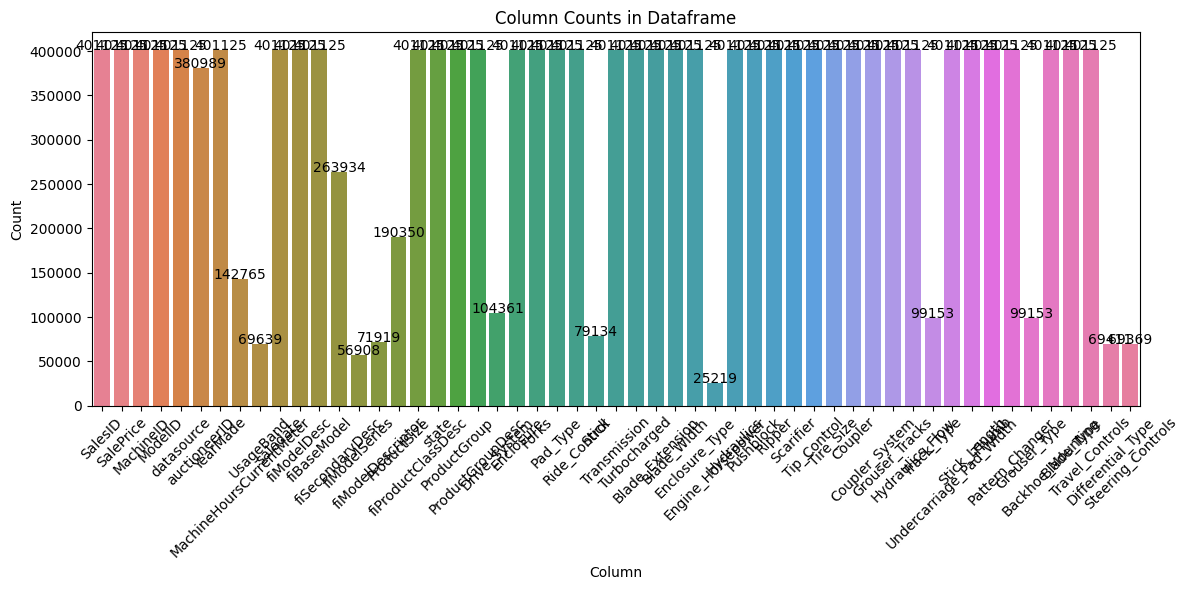

In [41]:
missing_values_histogram(df,df.columns)


In [42]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06


In [43]:
# Update the 'MachineHoursCurrentMeter' column: replace NaN or 0 with 0
column_name = 'MachineHoursCurrentMeter'

# Check if the column exists
if column_name in df.columns:
    df[column_name] = df[column_name].fillna(0)  # Replace NaN with 0
    df[column_name] = df[column_name].replace(0, 0)  # Ensure 0 stays 0
    print(f"Updated '{column_name}' column successfully!")
else:
    print(f"Column '{column_name}' does not exist in the DataFrame.")


df['auctioneerID'].max()
df['auctioneerID'].min()

# Fill null values in the 'auctioneerID' column with 100.0
if 'auctioneerID' in df.columns:
    df['auctioneerID'] = df['auctioneerID'].fillna(100.0)
    print("'auctioneerID' null values filled with 100.0 successfully!")
else:
    print("Column 'auctioneerID' does not exist in the DataFrame.")


Updated 'MachineHoursCurrentMeter' column successfully!
'auctioneerID' null values filled with 100.0 successfully!


In [44]:
# Example usage:
df = drop_columns_with_high_nulls(df, threshold=500)
print(df.head())

Dropped columns: ['UsageBand', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'Drive_System', 'Stick', 'Engine_Horsepower', 'Track_Type', 'Grouser_Type', 'Differential_Type', 'Steering_Controls']
   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.0      2001   
4  1139253      11000    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter         saledate fiModelDesc  ...  \
0                      68.0  11/16/2006 0:00        521D  ...   
1                    4640.0   3/26/2004 0:00      950FII  ...   
2                    2838.0   2/26/2004 0:00         226  ...   
3                    3486.0   5/

In [45]:
show_unique_values(df,'Enclosure')

In [46]:
df=convert_date_columns(df,'saledate')
df.head()


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,...,Thumb,Pattern_Changer,Backhoe_Mounting,Blade_Type,Travel_Controls,year,month,day,day_of_week,is_weekend
0,1139246,66000,999089,3157,121,3.0,2004,68.0,521D,521,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,2006,11,16,3,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,950FII,950,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,2004,3,26,4,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,226,226,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,2004,2,26,3,False
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,PC120-6E,PC120,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,2011,5,19,3,False
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,S175,S175,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,2009,7,23,3,False


In [47]:
df=encode_all_categories(df)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,...,Thumb,Pattern_Changer,Backhoe_Mounting,Blade_Type,Travel_Controls,year,month,day,day_of_week,is_weekend
0,1139246,66000,999089,3157,121,3.0,2004,68.0,949,295,...,2,1,0,4,5,2006,11,16,3,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,1724,526,...,2,1,0,4,5,2004,3,26,4,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,330,109,...,2,1,0,4,5,2004,2,26,3,False
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,3673,1374,...,2,1,0,4,5,2011,5,19,3,False
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,4207,1528,...,2,1,0,4,5,2009,7,23,3,False


In [48]:
sampled_df = df.sample(n=25000, random_state=42)  # Example: 10,000 rows

model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22875.826680148548
Train RMSE: 3882.599286980137
Test RMSE: 10469.491272688781
Test RMSLE: 0.311724432638288


In [49]:
sampled_df=find_outliers(df=sampled_df,column_to_predict='SalePrice')
print(sampled_df)

        SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
347851  2404577      35000    1123369     9133         136           7.0   
361528  2501703      27000    1448367    22353         149           1.0   
296035  2227746      66000    1062020     4035         136           3.0   
165866  1590101      43000    1116102     8165         132           6.0   
303180  2248487      92000    1224931     4149         136           1.0   
...         ...        ...        ...      ...         ...           ...   
135819  1493894      37000    1272987     2759         132           1.0   
68214   1344737      33000     651831     4124         132          19.0   
10508   1174457      43000    1043454     3362         121           3.0   
172913  1602017      32000    1489667    22057         132           2.0   
301605  2244611      70000    1080310     2768         136           1.0   

        YearMade  MachineHoursCurrentMeter  fiModelDesc  fiBaseModel  ...  \
347851    

In [50]:
# Assuming df_with_anomalies is the DataFrame containing anomaly labels
anomalies = sampled_df[sampled_df['anomaly_label'] == 'Anomaly']

# Display rows where 'anomaly_label' is 'Anomaly'
print(anomalies)

# Optionally, display the count of anomalies
print(f"Number of anomalies detected: {len(anomalies)}")


        SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
350385  2412716      38000    1018549    23618         136         100.0   
99092   1416655      53000    1112126     3357         132           1.0   
83344   1384097      67500    1196808    23926         132           1.0   
99845   1417721      85000    1085895     3357         132          99.0   
389051  4363706      46000    1268253    16673         172           1.0   
...         ...        ...        ...      ...         ...           ...   
216993  1682431      12000    1173914     8733         132          99.0   
317630  2292972      16000     824275     3539         136         100.0   
394308  6267798      49000    1233386     3362         149           1.0   
2852    1148771      35000    1065675    11952         121           3.0   
110788  1445330      28000     916775     3362         132          99.0   

        YearMade  MachineHoursCurrentMeter  fiModelDesc  fiBaseModel  ...  \
350385    

In [51]:
# Remove all rows where 'anomaly_label' is 'Anomaly'
sampled_df = sampled_df[sampled_df['anomaly_label'] != 'Anomaly']

# Drop the columns 'anomaly_label', 'anomaly_score', and 'anomaly'
columns_to_drop = ['anomaly_label', 'anomaly_score', 'anomaly']
sampled_df = sampled_df.drop(columns=columns_to_drop, errors='ignore')

# Display the updated DataFrame
print(sampled_df.head())

# Optionally display the new shape of the DataFrame
print(f"New DataFrame shape: {sampled_df.shape}")


        SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
347851  2404577      35000    1123369     9133         136           7.0   
361528  2501703      27000    1448367    22353         149           1.0   
296035  2227746      66000    1062020     4035         136           3.0   
165866  1590101      43000    1116102     8165         132           6.0   
303180  2248487      92000    1224931     4149         136           1.0   

        YearMade  MachineHoursCurrentMeter  fiModelDesc  fiBaseModel  ...  \
347851      2005                       0.0         4858         1873  ...   
361528      2003                    3013.0         1579          469  ...   
296035      1988                    4388.0         1950          670  ...   
165866      1990                    1060.0          905          283  ...   
303180      1993                       0.0         2366          715  ...   

        Thumb  Pattern_Changer  Backhoe_Mounting  Blade_Type  Travel_Controls  \

In [52]:
feature_importances(model)

Enclosure                   1.720052e-01
YearMade                    1.527178e-01
fiProductClassDesc          1.099940e-01
ModelID                     8.606935e-02
year                        6.533887e-02
fiModelDesc                 6.022912e-02
Hydraulics_Flow             5.139858e-02
SalesID                     4.428739e-02
MachineID                   4.350887e-02
fiBaseModel                 3.915491e-02
Blade_Type                  1.934554e-02
day                         1.660668e-02
state                       1.653172e-02
month                       1.337276e-02
Travel_Controls             1.214775e-02
ProductGroupDesc            1.109011e-02
ProductGroup                1.024272e-02
auctioneerID                8.708599e-03
day_of_week                 8.431256e-03
Ripper                      7.801960e-03
MachineHoursCurrentMeter    7.675454e-03
Hydraulics                  7.125510e-03
Ride_Control                6.347021e-03
Stick_Length                4.913594e-03
Tire_Size       

,0
Enclosure,1.720052e-01
YearMade,1.527178e-01
fiProductClassDesc,1.099940e-01
ModelID,8.606935e-02
year,6.533887e-02
fiModelDesc,6.022912e-02
Hydraulics_Flow,5.139858e-02
SalesID,4.428739e-02
MachineID,4.350887e-02
fiBaseModel,3.915491e-02


In [53]:
model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22137.449684210413
Train RMSE: 3882.1152617620282
Test RMSE: 10255.514061516076
Test RMSLE: 0.309587241724312


In [54]:
importance_model=perm_importance_model(model,xs)

,Feature,Permutation Importance,Permutation Std Deviation,Model Importance,Permutation Rank,Model Rank
5,YearMade,7.120065e-01,5.478920e-03,1.917341e-01,1.0,1.0
39,year,2.177013e-01,5.623049e-03,6.966776e-02,2.0,6.0
13,Enclosure,1.373562e-01,6.557960e-03,1.159860e-01,3.0,2.0
9,fiProductClassDesc,1.193693e-01,2.908899e-03,7.938145e-02,4.0,4.0
2,ModelID,1.184395e-01,2.733053e-03,8.248743e-02,5.0,3.0
7,fiModelDesc,9.366396e-02,2.858343e-03,7.346034e-02,6.0,5.0
12,ProductGroupDesc,6.061463e-02,1.031359e-03,3.859933e-02,7.0,10.0
11,ProductGroup,5.294329e-02,1.012492e-03,3.740857e-02,8.0,11.0
8,fiBaseModel,4.070742e-02,1.699170e-03,5.172896e-02,9.0,7.0
0,SalesID,2.675383e-02,1.092504e-03,4.169307e-02,10.0,9.0


In [55]:
# Drop columns where 'Permutation Importance' is less than 0.02
importance_model_filtered = importance_model[importance_model['Permutation Importance'] >= 0.02]

# Display the filtered DataFrame
print(importance_model_filtered)

# Optionally, list the dropped columns
dropped_columns = importance_model[importance_model['Permutation Importance'] < 0.02]['Feature']
print("Dropped columns:", dropped_columns.tolist())
sampled_df.drop(columns=dropped_columns, inplace=True)

#


               Feature  Permutation Importance  Permutation Std Deviation  \
5             YearMade                0.712006                   0.005479   
39                year                0.217701                   0.005623   
13           Enclosure                0.137356                   0.006558   
9   fiProductClassDesc                0.119369                   0.002909   
2              ModelID                0.118439                   0.002733   
7          fiModelDesc                0.093664                   0.002858   
12    ProductGroupDesc                0.060615                   0.001031   
11        ProductGroup                0.052943                   0.001012   
8          fiBaseModel                0.040707                   0.001699   
0              SalesID                0.026754                   0.001093   
31     Hydraulics_Flow                0.023273                   0.001333   
22          Hydraulics                0.022203                   0.000693   

In [56]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24750 entries, 347851 to 301605
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   SalesID             24750 non-null  int64
 1   SalePrice           24750 non-null  int64
 2   ModelID             24750 non-null  int64
 3   YearMade            24750 non-null  int64
 4   fiModelDesc         24750 non-null  int16
 5   fiBaseModel         24750 non-null  int16
 6   fiProductClassDesc  24750 non-null  int8 
 7   ProductGroup        24750 non-null  int8 
 8   ProductGroupDesc    24750 non-null  int8 
 9   Enclosure           24750 non-null  int8 
 10  Hydraulics          24750 non-null  int8 
 11  Hydraulics_Flow     24750 non-null  int8 
 12  year                24750 non-null  int32
dtypes: int16(2), int32(1), int64(4), int8(6)
memory usage: 1.3 MB


In [57]:
model,xs=train_model(df=sampled_df,column_to_predict='SalePrice')


RMSE Baseline accuracy: 22137.449684210413
Train RMSE: 3724.729337958691
Test RMSE: 9701.787002954688
Test RMSLE: 0.2977804321048645


In [58]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load the file from Google Drive
file_path = "/content/drive/My Drive/Train.csv"  # Replace with the saved file path
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-58-45d8dd70e0bd>:8: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.0      2001   
4  1139253      11000    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand         saledate  ...  \
0                      68.0       Low  11/16/2006 0:00  ...   
1                    4640.0       Low   3/26/2004 0:00  ...   
2                    2838.0      High   2/26/2004 0:00  ...   
3                    3486.0      High   5/19/2011 0:00  ...   
4                     722.0    Medium   7/23/2009 0:00  ...   

  Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
0                     NaN          NaN   NaN             

In [59]:
update_NaN_To_None_or_Unspecified(df)

Column 'SalesID' does not have the required conditions for update.
Column 'SalePrice' does not have the required conditions for update.
Column 'MachineID' does not have the required conditions for update.
Column 'ModelID' does not have the required conditions for update.
Column 'datasource' does not have the required conditions for update.
Column 'auctioneerID' does not have the required conditions for update.
Column 'YearMade' does not have the required conditions for update.
Column 'MachineHoursCurrentMeter' does not have the required conditions for update.
Column 'UsageBand' does not have the required conditions for update.
Column 'saledate' does not have the required conditions for update.
Column 'fiModelDesc' does not have the required conditions for update.
Column 'fiBaseModel' does not have the required conditions for update.
Column 'fiSecondaryDesc' does not have the required conditions for update.
Column 'fiModelSeries' does not have the required conditions for update.
Column 

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,10/25/2011 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN


In [60]:
# Update the 'MachineHoursCurrentMeter' column: replace NaN or 0 with 0
column_name = 'MachineHoursCurrentMeter'

# Check if the column exists
if column_name in df.columns:
    df[column_name] = df[column_name].fillna(0)  # Replace NaN with 0
    df[column_name] = df[column_name].replace(0, 0)  # Ensure 0 stays 0
    print(f"Updated '{column_name}' column successfully!")
else:
    print(f"Column '{column_name}' does not exist in the DataFrame.")


df['auctioneerID'].max()
df['auctioneerID'].min()

# Fill null values in the 'auctioneerID' column with 100.0
if 'auctioneerID' in df.columns:
    df['auctioneerID'] = df['auctioneerID'].fillna(100.0)
    print("'auctioneerID' null values filled with 100.0 successfully!")
else:
    print("Column 'auctioneerID' does not exist in the DataFrame.")


Updated 'MachineHoursCurrentMeter' column successfully!
'auctioneerID' null values filled with 100.0 successfully!


In [61]:
df=convert_date_columns(df,'saledate')
df.head()


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,year,month,day,day_of_week,is_weekend
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,521D,...,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional,2006,11,16,3,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,950FII,...,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional,2004,3,26,4,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,226,...,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN,2004,2,26,3,False
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN,2011,5,19,3,False
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN,2009,7,23,3,False


In [62]:
df=encode_all_categories(df)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,year,month,day,day_of_week,is_weekend
0,1139246,66000,999089,3157,121,3.0,2004,68.0,1,949,...,0,4,5,3,1,2006,11,16,3,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,1,1724,...,0,4,5,3,1,2004,3,26,4,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,0,330,...,0,4,5,-1,-1,2004,2,26,3,False
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,0,3673,...,0,4,5,-1,-1,2011,5,19,3,False
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,2,4207,...,0,4,5,-1,-1,2009,7,23,3,False


In [63]:
import pandas as pd

# Compute correlation matrix
corr_matrix = df.corr()

# Find highly correlated features (e.g., correlation > 0.85)
high_corr_features = set()
threshold = 0.85

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

print("Highly correlated features:", high_corr_features)


Highly correlated features: {'ProductGroupDesc', 'Stick', 'Steering_Controls', 'fiBaseModel'}


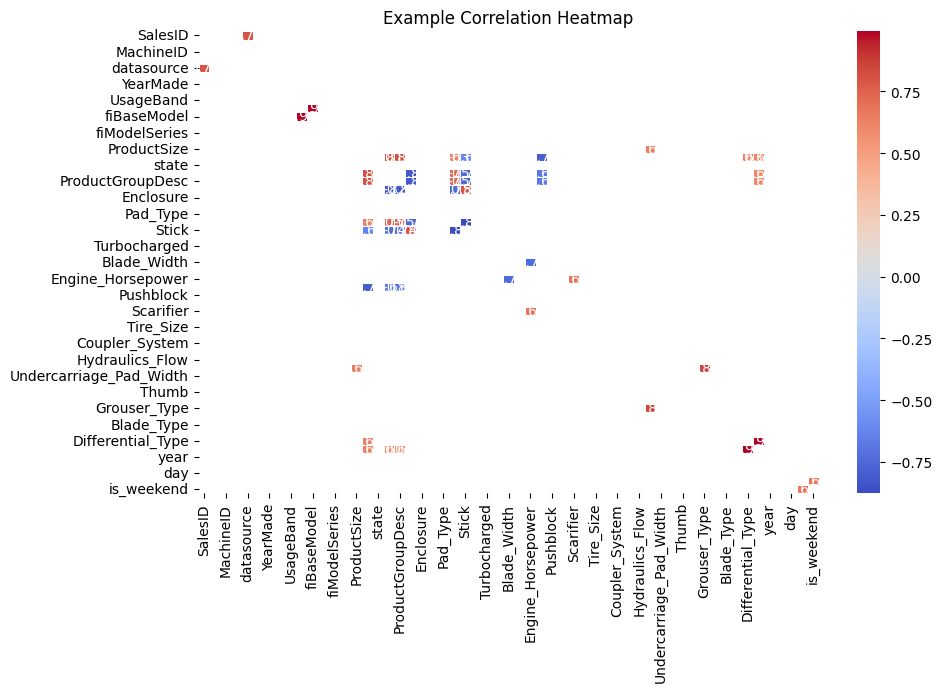

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()
threshold = 0.60

# Apply threshold filter to only show correlations above 0.5
filtered_corr = corr_matrix[(abs(corr_matrix) > threshold) & (abs(corr_matrix) < 1)]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Example Correlation Heatmap")
plt.show()


In [65]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load the file from Google Drive
file_path = "/content/drive/My Drive/Train.csv"  # Replace with the saved file path
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-65-45d8dd70e0bd>:8: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.0      2001   
4  1139253      11000    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand         saledate  ...  \
0                      68.0       Low  11/16/2006 0:00  ...   
1                    4640.0       Low   3/26/2004 0:00  ...   
2                    2838.0      High   2/26/2004 0:00  ...   
3                    3486.0      High   5/19/2011 0:00  ...   
4                     722.0    Medium   7/23/2009 0:00  ...   

  Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
0                     NaN          NaN   NaN             